In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, ops
from jax import random
import numpy as np
import jax
from jax.scipy.linalg import expm
from jax.scipy import linalg
import eigAD


In [2]:
# tunning parameter (constant in grad)
numStates=25
numSteps=31
numBands=5
fr=25.18
kpoints=250
kvec=jnp.linspace(-1,0,kpoints)

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


C = []
for i in range(2,numStates,2):
    C = C + [0,i]
C = np.array(C)
D = np.zeros(numStates)
M1 = tridiag(C,D,-1 * C)

E = [0]
for i in range(2,numStates,2):
    E = E + [(i)**2,(i)**2]
M2 = np.array(-np.diag(E))


F = np.concatenate((np.array([np.sqrt(2)]) , np.ones(numStates-3)))
M3 = np.diag(F,-2) + np.diag(F,2)

In [10]:
# freqs: driving frequencies
# alphas: driving strength

M1 = jnp.asarray(M1,dtype=jnp.complex64)
M2 = jnp.asarray(M2,dtype=jnp.complex64)
M3 = jnp.asarray(M3,dtype=jnp.complex64)

def computeFloquetLoss(freq,alpha,A):
    lcm = 1/freq
    Ttot =  lcm 
    ftot = 1/Ttot
    
    dT = (1/freq)/numSteps

    N = int(jnp.ceil(Ttot/dT))

    tVec = jnp.linspace(0,Ttot,N)
    dT = tVec[1] - tVec[0]
    tVec = tVec[:-1]
    tVec = tVec + dT/2
    dTau = (2 * jnp.pi * fr) * dT

    @jax.jit
    def perKstep(k):
        unitaryInit = jnp.identity(M1.shape[0],dtype=jnp.complex64)

        @jax.jit
        def scanf(unitary,t):
            dU = expm(-1j * dTau * createHmat(t,k))
            dU = jnp.asarray(dU,dtype=jnp.complex64)
            unitary = jnp.asarray(unitary,dtype=jnp.complex64)
            unitary = jnp.matmul(unitary,dU)
            return unitary,0

        res, _ = jax.lax.scan(scanf,unitaryInit,tVec)
        return res

    @jax.jit
    def createHmat(t,k):
        modfunc = 1 + jnp.sum(alpha * jnp.sin(2 * jnp.pi * freq * t))
        newMat = (k**2) * jnp.identity(numStates,dtype=jnp.complex64) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A * modfunc
        return jnp.asarray(newMat,dtype=jnp.complex64)

    def genUni():
        kMap = vmap(perKstep)
        return kMap(kvec)

    res = genUni()

    def eigWrapper(mat):
        return eigAD.eig(mat)

    eigWrapper= jax.jit(eigWrapper,backend='cpu')
    eigWrapper= vmap(eigWrapper)
    b,vF = eigWrapper(res)
    rawEfloquet = jnp.real(1j*jnp.log(b)* (ftot/fr) / (2*np.pi))
    
    @jax.jit
    def blochStates(i):
        k = kvec[i]
        currF = vF[i,:,:] 
        H0 =  (k**2) * jnp.identity(numStates) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A 
        a,vS = jnp.linalg.eigh(H0)
        vS = jnp.transpose(vS)
        Cvec = jnp.matmul(vS,jnp.conjugate(currF))
        Pvec = jnp.multiply(Cvec,jnp.conjugate(Cvec))
        inds = jnp.argmax(jnp.real(Pvec),axis=1)
        Efloquet = rawEfloquet[i,inds[:numBands]]
        return Efloquet
    bandsF = vmap(blochStates)(jnp.arange(250))

    return bandsF
    
    


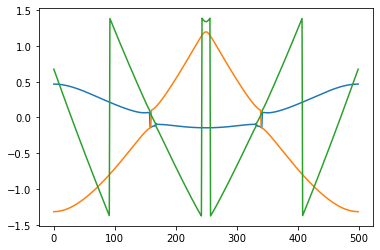

In [12]:
bandsF = computeFloquetLoss(70.0,0.5,2.0)
mirror = jnp.flip(bandsF,axis=0)
bandsF = jnp.concatenate((bandsF,mirror),axis=0)
import matplotlib.pyplot as plt
plt.plot(bandsF[:,:3])

In [5]:
padeCoefA = (0,1,5/2,74/33,19/22,29/220,7/1320)
padeCoefB = (1,3,75/22,20/11,5/11,1/221,1/924)

@jax.jit
def logm(mat):
    Npq = jnp.zeros(mat.shape)
    Dpq = jnp.identity(mat.shape[0])
    
    for i in range(1,7):
        curr = jnp.linalg.matrix_power(mat - jnp.identity(mat.shape[0]),i)
        Npq += padeCoefA[i] * curr
        Dpq += padeCoefB[i] * curr
        
    return jnp.linalg.inv(Dpq) @ Npq
